# Eesmärk
Luua mudel, millega saab mängu juhtida vastvalt paremale, vasakule või käivitada võimed 'power'.


In [5]:
#Moodulite installimine
import numpy as np
import os 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

# Käeliigutusteks
from random import randint
import keras
from keras.utils import to_categorical
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split

# Näo tuvastus
import cv2 as cv
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import copy
import math

## Mängu juhtimine käeliigutustega


Kasutusel on Kaggelist alla laetud žestide andmestik, mis on leitav siin: https://www.kaggle.com/gti-upm/leapgestrecog
Mängu juhtimiseks on vaja kasutada kolme käsku: vasakule, paremale ja power. Antud andmestik sisaldab 10 erinevat žesti ning otsustasime katsetada 2 eri varianti:

1) Andmestik, kus on kasutusel kõik 10 käeliigutust

2) Andmestik, kus on kasutusel 4 erinevat käeliigutust


In [3]:
# EELTÖÖTLUS
# Funktsioon andmete töötlemiseks. Saame kasutada mõlema andmestiku puhul (10 ja 4 erinevat käeliigutust)

def tootleAndmeid(pathToFiles):
    lookup = dict()
    reverselookup = dict()
    count = 0

    # Kuna kõik pildid on salvestatud nimelistesse kaustadesse, siis loeme need sisse, ning lisame,
    # mitmendad nad meie järjendis on.
    for j in os.listdir(pathToFiles +'0/'):
        if not j.startswith('.'): # Kuna jooksutame koodi lokaalselt, siis ei taha me sisse lugeda peidetudi kausti 
            lookup[j] = count
            reverselookup[count] = j
            count = count + 1
    lookup #prindime välja meie järjendi, kus hoidlustame andmeid
    
    # Järgmisena jagame andmed 2 järjendisse:
    x_data = [] # Pilt
    y_data = [] # Mis klassi pilt kuulub
    datacount = 0 # Loendame kokku, mitu pilti on meie andmestikus

    for i in range(0, 10): # Käime läbi kõik 10 kausta, kus pildid asuvad
        for j in os.listdir(pathToFiles + str(i) + '/'): # Võtame vastava kausta
            if not j.startswith('.'): # Väldime lokaalseid peidetuid kausti
                count = 0 # Loendame kokku kaustas asuvad pildid
                for k in os.listdir(pathToFiles + str(i) + '/' + j + '/'): # Käime kõik pildid läbi                            
                    # Avame pildi ja viime vastavale kujule: 'grayscale' + mõõtmed
                    img = Image.open(pathToFiles + str(i) + '/' + j + '/' + k).convert('L')
                    img = img.resize((320, 120))

                    # Viime pildi järjendi kujule ning lisame selle x_data järjendisse
                    arr = np.array(img)
                    x_data.append(arr) 
                    count = count + 1 # Suurendame loendajat
                # Lisame vastava klassi
                y_values = np.full((count, 1), lookup[j]) 
                y_data.append(y_values)
                datacount = datacount + count

    # Viime õigele kujule           
    x_data = np.array(x_data, dtype = 'float32')
    y_data = np.array(y_data)
    y_data = y_data.reshape(datacount, 1)
    return x_data, y_data

x_4, y_4 = tootleAndmeid('4HandGest/leapGestRecog/0')
print('Andmestik 4 käe liigutusega')
print(x_4.shape)
print(y_4.shape)

x_10, y_10 = tootleAndmeid('10HandGest/leapGestRecog/0')
print('Andmestik 10 käe liigutusega')
print(x_10.shape)
print(y_10.shape)

Andmestik 4 käe liigutusega
(8000, 120, 320)
(8000, 1)
Andmestik 10 näe liigutusega
(20000, 120, 320)
(20000, 1)


## Mudel nelja käeliigutusega

Vajaminevad käeliigutused:
* Vasak - 'c'
* Parem - 'palm'
* Power - 'pöial'

Ning kuna tahame, et mängu mehike seisaks kohapeal (st. ei liigu), siis mugavuseks on lisatud ka 'fist'.

In [4]:
# Andmete visualiseerimiseks prindime suvaliselt välja iga klassi esindaja
for i in range(0, 4):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

NameError: name 'x_data' is not defined

In [78]:
# Kuna ennustame 4 kategooria vahel, viime y andmed õigele kujule
y_data = to_categorical(y_data)
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

# Jagame andmed treenimiseks ja valideerimiseks
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)


In [79]:
# Loome mudeli

model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))



In [80]:
# Treenime loodud mudeli
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))


Epoch 1/10
100/100 [==============================] - 75s 737ms/step - loss: 0.6142 - accuracy: 0.7433 - val_loss: 0.0172 - val_accuracy: 0.9962
Epoch 2/10
100/100 [==============================] - 74s 743ms/step - loss: 0.0407 - accuracy: 0.9908 - val_loss: 0.0120 - val_accuracy: 0.9975
Epoch 3/10
100/100 [==============================] - 74s 740ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0100 - val_accuracy: 0.9975
Epoch 4/10
100/100 [==============================] - 74s 740ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.0138 - val_accuracy: 0.9950
Epoch 5/10
100/100 [==============================] - 72s 724ms/step - loss: 3.9042e-04 - accuracy: 0.9998 - val_loss: 0.0131 - val_accuracy: 0.9962
Epoch 6/10
100/100 [==============================] - 72s 716ms/step - loss: 2.2003e-05 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9975
Epoch 7/10
100/100 [==============================] - 72s 719ms/step - loss: 8.2614e-08 - accuracy: 1.0000 - val_loss: 0.0

In [81]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

25/25 [==============================] - 3s 94ms/step - loss: 0.0127 - accuracy: 0.9987
Accuracy:0.9987499713897705


In [84]:
# Enne jooksutamist kustuta nn mudel
model.save("nn")

INFO:tensorflow:Assets written to: nn\assets


In [83]:
#modeln = keras.models.load_model("nn")

#img = Image.open('leapgestrecog/leapGestRecog/02/03_fist/frame_02_03_0003.png').convert('L')
#img = img.resize((320, 120))
#arr = np.array(img, dtype='float32')
#arr = arr.reshape((1, 120, 320, 1))
#print(modeln.predict(arr))

## Näo järgi juhtimine

In [7]:
def näitaPilti(pilt):
    #lokaalselt parema kvalliga
    #cv.imshow('Test pilt', pilt) 
    #cv.waitKey(0)
    #cv.destroyAllWindows()
    
    #cv2_imshow(img) #colabi jaoks
    
    plt.subplot(111),plt.imshow(pilt),plt.title('Pilt')
    plt.show()

In [8]:
testPildid = []

i = 1
while True:
    try:
        p = cv.imread(f"face_command_details/fbi_picture{i}.png")
        len(p) #viskab errori kui pilti ei ole
        testPildid.append(p)
        i += 1
    except:
        break

face_cascade = cv.CascadeClassifier("face_command_details/haarcascade_frontalface_default.xml")
eye_cascade = cv.CascadeClassifier("face_command_details/haarcascade_eye.xml")
smile_cascade = cv.CascadeClassifier('face_command_details/haarcascade_smile.xml') 

In [9]:
def teostaTuvastus(img):
    koopia = img.copy() 
    gray = cv.cvtColor(koopia, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
   
    eyes = []
    smiles = []
    for (x, y, w, h) in faces:
        cv.rectangle(koopia, (x, y), (x+w, y+h), (0, 0, 255), 2)
        roi_gray = gray[y:y + h, x : x + h]
        roi_color = koopia[y:y + h, x : x + h]
     
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 255), 2)
            
        smiles = smile_cascade.detectMultiScale(roi_gray, 1.8, 20) 
        for (sx, sy, sw, sh) in smiles: 
            cv.rectangle(roi_color, (sx, sy), ((sx + sw), (sy + sh)), (0, 0, 255), 2) 
            
    
    print(f"Silmi {len(eyes)}")
    print(f"Naeratusi {len(smiles)}")
    print("Silmade andmed:")
    for s in eyes:
        print(s)

    näitaPilti(koopia)

Pilt 0:
Silmi 2
Naeratusi 0
Silmade andmed:
[122  58  49  49]
[37 56 53 53]


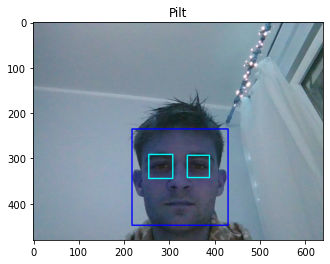

Pilt 1:
Silmi 2
Naeratusi 1
Silmade andmed:
[132  60  45  45]
[40 57 54 54]


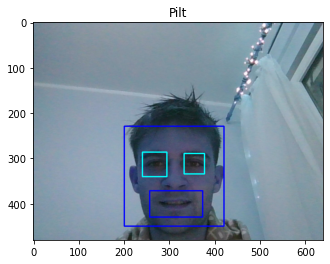

Pilt 2:
Silmi 0
Naeratusi 0
Silmade andmed:


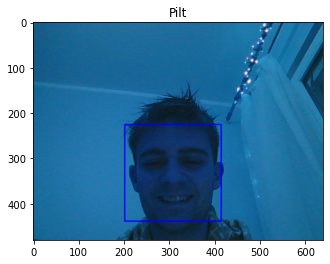

Pilt 3:
Silmi 1
Naeratusi 1
Silmade andmed:
[120  55  61  61]


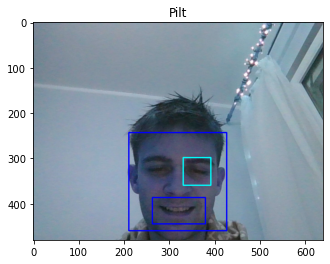

Pilt 4:
Silmi 2
Naeratusi 0
Silmade andmed:
[113  43  54  54]
[46 76 50 50]


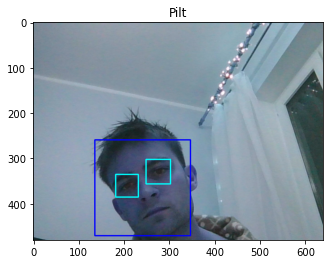

Pilt 5:
Silmi 0
Naeratusi 0
Silmade andmed:


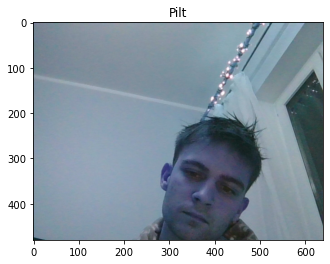

Pilt 6:
Silmi 0
Naeratusi 0
Silmade andmed:


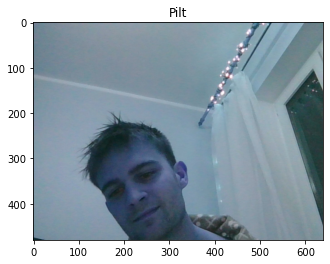

Pilt 7:
Silmi 0
Naeratusi 0
Silmade andmed:


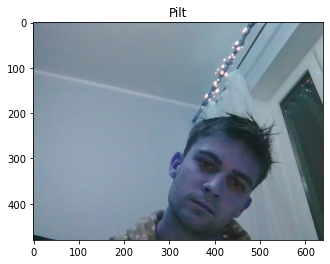

Pilt 8:
Silmi 2
Naeratusi 0
Silmade andmed:
[46 44 43 43]
[113  65  48  48]


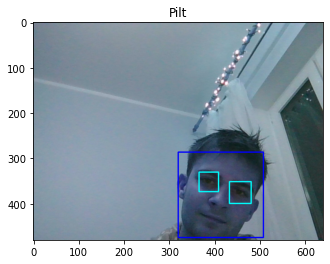

Pilt 9:
Silmi 2
Naeratusi 0
Silmade andmed:
[33 59 52 52]
[121  52  52  52]


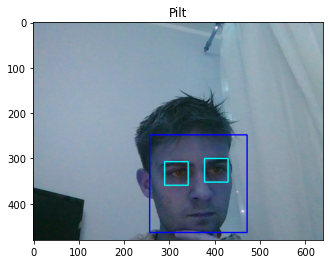

In [10]:
for i, img in enumerate(testPildid):
    print(f"Pilt {i}:")
    teostaTuvastus(img)

In [11]:
"""
    Tagastus listina võimalikest väärtustest:
    'vasak'
    'parem'
    'power'
"""
def ennusta(img):
    koopia = img.copy() 
    gray = cv.cvtColor(koopia, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
   
    eyes = []
    smiles = []
    for (x, y, w, h) in faces:
        cv.rectangle(koopia, (x, y), (x+w, y+h), (0, 0, 255), 2)
        roi_gray = gray[y:y + h, x : x + h]
        roi_color = koopia[y:y + h, x : x + h]
        eyes = eye_cascade.detectMultiScale(roi_gray)   
        smiles = smile_cascade.detectMultiScale(roi_gray, 1.8, 20)
    
    vastused = []
    if len(smiles) == 1:
        vastused.append("power")
    
    if len(eyes) == 2:
        #silmade koordinaadid x,y (tuvastuse keskpunkt)
        kesk1 = (eyes[0][0] + int(eyes[0][2] / 2), eyes[0][1] + int(eyes[0][3] / 2))
        kesk2 = (eyes[1][0] + int(eyes[1][2] / 2), eyes[1][1] + int(eyes[1][3] / 2))
        
        if (kesk1[0] < kesk2[0]):
            vasak = kesk1
            parem = kesk2
        else:
            vasak = kesk2
            parem = kesk1
            
        tolerants = 20
        vahe = vasak[1] - parem[1]

            
        if vahe > tolerants:
            vastused.append("paremale")
        if vahe < -tolerants:
            vastused.append("vasakule")
    return vastused

In [12]:
for i, img in enumerate(testPildid):
    print(f"Pilt {i}:")
    print(ennusta(img))
    print()

Pilt 0:
[]

Pilt 1:
['power']

Pilt 2:
[]

Pilt 3:
['power']

Pilt 4:
['paremale']

Pilt 5:
[]

Pilt 6:
[]

Pilt 7:
[]

Pilt 8:
['vasakule']

Pilt 9:
[]

